<a href="https://colab.research.google.com/github/yajuna/linearRegression/blob/master/linear_regression(version2_0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this notebook, we play with measured weather data and measured tree temperature, and try to fit a simple linear regression model. We will Oct 21 data for training the model, and Oct 22 to test the model.
As these two days are close, they will probably have similar weather conditions; next step is to find dates that are far apart from Oct 21, and predict the temperature from different weather condtions.



In [32]:
import numpy as np
import pandas
# import random
# from scipy import sparse
from matplotlib import pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import sys
print("Python 3 version is", sys.version)
import matplotlib
print("Matplotlib version is", matplotlib.__version__)
print("Numpy version is", np.__version__)
import scipy

print("Scipy version is", scipy.__version__)

Python 3 version is 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
Matplotlib version is 3.7.1
Numpy version is 1.22.4
Scipy version is 1.10.1


In [33]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing

Define parameters for linear interpolation of temperature and weather data

In [34]:
# define parameter
n_t = 4000
n_x = 2000
radius = 0.135 # unit m
time = np.linspace(0, 24, n_t, endpoint = False)

## Use data from Oct 21 for training.
From tree temperature data, read core and bark temperature as indepedent variables $X$; read mid_temp1 (at depth 9cm) and mid_temp2 (at depth 4.5cm) as dependent variables $Y$.
From weather data, read wind_speed, wind_direction, humidity, temperature, air_pressure, solar_DNI. wind direction is unlikely to have a linear relation to the temperature, so we delete it from independent variables.

In [35]:
train_tree_temp_index = 416 - 2
train_weather_index = 145 - 2

test_tree_temp_index = 827 - 2
test_weather_index = 289 -2

train_interp_temp_size = train_tree_temp_index
train_interp_weather_size = train_weather_index

test_interp_temp_size = test_tree_temp_index - train_tree_temp_index
test_interp_weather_size = test_weather_index - train_weather_index

In [36]:
colnames = ['datetime', 's45_1', 'e9_1', 'n135_1','e45_2', 'n9_2', 'w135_2', 'n45_3', 'w9_3','s135_3', 'w_ext_35']
url1 = "https://raw.githubusercontent.com/yajuna/linearRegression/master/Tree_Temp_Values_OCT21_to_OCT28_2022.xlsx"
dataTemp = pandas.read_excel(url1,names=colnames)
# dataTemp = pandas.read_excel('Tree_Temp_Values_OCT21_to_OCT28_2022.xlsx', names=colnames)

# training data processing- measured temp of tree at various depths

# core temp is west, at 13.5cm, at 2m high
train_coreTemp = np.array(dataTemp.s135_3[:train_tree_temp_index])+ 273.15
# West, at 9cm, at 3m high
train_midTemp1 = np.array(dataTemp.w9_3[:train_tree_temp_index])+ 273.15
# North, at 4.5cm, at 3m high
train_midTemp2 = np.array(dataTemp.n45_3[:train_tree_temp_index])+ 273.15
# bark temp is West, at bark, at 3.5m high
train_barkTemp = np.array(dataTemp.w_ext_35[:train_tree_temp_index])+ 273.15

# linear interpolate the measured temperature
train_coreTemp = np. interp(time, np.linspace(0,24,train_interp_temp_size),train_coreTemp)
train_midTemp1 = np. interp(time, np.linspace(0,24,train_interp_temp_size),train_midTemp1)
train_midTemp2 = np. interp(time, np.linspace(0,24,train_interp_temp_size),train_midTemp2)
train_barkTemp = np. interp(time, np.linspace(0,24,train_interp_temp_size),train_barkTemp)

# testing data processing- measured temp of tree at various depths

# core temp is west, at 13.5cm, at 2m high
test_coreTemp = np.array(dataTemp.s135_3[train_tree_temp_index: test_tree_temp_index])+ 273.15
# West, at 9cm, at 3m high
test_midTemp1 = np.array(dataTemp.w9_3[train_tree_temp_index: test_tree_temp_index])+ 273.15
# North, at 4.5cm, at 3m high
test_midTemp2 = np.array(dataTemp.n45_3[train_tree_temp_index: test_tree_temp_index])+ 273.15
# bark temp is West, at bark, at 3.5m high
test_barkTemp = np.array(dataTemp.w_ext_35[train_tree_temp_index: test_tree_temp_index])+ 273.15

# linear interpolate the measured temperature
test_coreTemp = np. interp(time, np.linspace(0,24,test_interp_temp_size),test_coreTemp)
test_midTemp1 = np. interp(time, np.linspace(0,24,test_interp_temp_size),test_midTemp1)
test_midTemp2 = np. interp(time, np.linspace(0,24,test_interp_temp_size),test_midTemp2)
test_barkTemp = np. interp(time, np.linspace(0,24,test_interp_temp_size),test_barkTemp)

print("measured temperature data read")

measured temperature data read


In [37]:
### Read weather data

colnames = ['datetime', 'wind_speed', 'wind_direction', 'humidity', 'air_temperature', 'air_pressure', 'solar_DNI']
url2 = "https://raw.githubusercontent.com/yajuna/linearRegression/master/Weather_Station_OCT21_to_OCT28_2022.xlsx"
dataWeather = pandas.read_excel(url2,names=colnames)
# dataWeather = pandas.read_excel('Weather_Station_OCT21_to_OCT28_2022.xlsx', names = colnames)


#### training
# wind speed from Oct 21
train_windSpeed = np.array(dataWeather.wind_speed[:train_weather_index])
# humidity from Oct 21
train_humidity = np.array(dataWeather.humidity[:train_weather_index])
# air temperature from Oct 21
train_airTemp = np.array(dataWeather.air_temperature[:train_weather_index])+ 273.15
# air pressure from Oct 21
train_airPressure = np.array(dataWeather.air_pressure[:train_weather_index])
# solar radiation from Oct 21
train_solar = np.array(dataWeather.solar_DNI[:train_weather_index])

train_airTemp = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,train_interp_weather_size),train_airTemp)
train_windSpeed = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,train_interp_weather_size),train_windSpeed)
train_solar = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,train_interp_weather_size),train_solar)

#### testing
# wind speed from Oct 21
test_windSpeed = np.array(dataWeather.wind_speed[train_weather_index: test_weather_index])
# humidity from Oct 21
test_humidity = np.array(dataWeather.humidity[train_weather_index: test_weather_index])
# air temperature from Oct 21
test_airTemp = np.array(dataWeather.air_temperature[train_weather_index: test_weather_index])+ 273.15
# air pressure from Oct 21
test_airPressure = np.array(dataWeather.air_pressure[train_weather_index: test_weather_index])
# solar radiation from Oct 21
test_solar = np.array(dataWeather.solar_DNI[train_weather_index: test_weather_index])

test_airTemp = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,test_interp_weather_size),test_airTemp)
test_windSpeed = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,test_interp_weather_size),test_windSpeed)
test_solar = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,test_interp_weather_size),test_solar)


print("weather data read")

weather data read


# Prepare training and testing data


In [38]:
Y1train = train_midTemp1
Y2train = train_midTemp2
Xtrain = [train_coreTemp, train_barkTemp, train_airTemp, train_windSpeed, train_solar]
X_train = np.array(Xtrain).T
Y_train = Y1train

Y1test = test_midTemp1
Y2test = test_midTemp2
Xtest = [test_coreTemp, test_barkTemp, test_airTemp, test_windSpeed, test_solar]
X_test = np.array(Xtest).T
Y_test = Y1test

In [39]:
model = LinearRegression()

In [40]:
model.fit(X_train,Y_train)

LinearRegression()

In [41]:
predictions = model.predict(X_test)

In [42]:
print(max(Y_test), min(Y_test), max(predictions), min(predictions))

299.46 297.71 299.6152207952709 297.290497396594


In [43]:
print(
  'mean_squared_error : ', mean_squared_error(Y_test, predictions))
print(
  'mean_absolute_error : ', mean_absolute_error(Y_test, predictions))

mean_squared_error :  0.10976414013148406
mean_absolute_error :  0.2691814919396762


In [47]:
print(max(abs(Y_test - predictions)))

0.6156526034059766


In [44]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 05:58:47


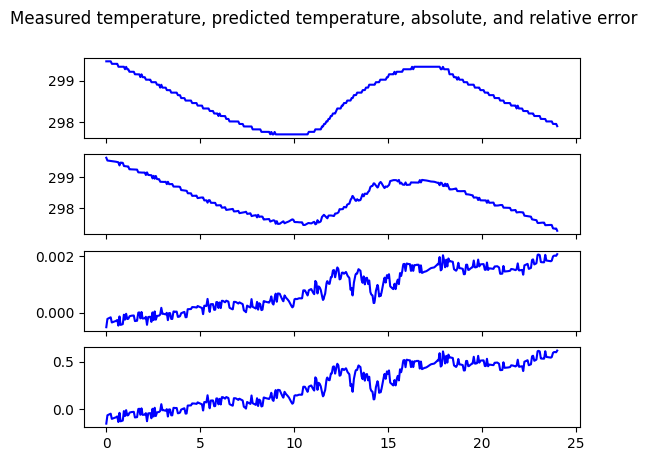

In [45]:
# visualization

fig, axs = plt.subplots(4, sharex=True, sharey=False)
fig.suptitle('Measured temperature, predicted temperature, absolute, and relative error')
axs[0].plot(time, Y_test, 'b-', label='testing values')
axs[1].plot(time, predictions, 'b-', label='predicted values')
axs[2].plot(time, (Y_test - predictions)/Y_test, 'b-', label='Relative error')
axs[3].plot(time, Y_test - predictions, 'b-', label='Absolute error')

plt.show()